# Bayesian Analysis of Math Exam Scores

## Problem Statement

You are provided with a dataset of math exam scores from Estonian primary schools. Your task is to build a Bayesian model to better understand the factors that influence exam performance.

## Data Description

The dataset includes the following variables:
- `year`: The year of the exam (2016-2023), with [2020 missing due to the COVID-19 pandemic](https://www.ohtuleht.ee/998159/pohikooli-eksamid-jaavad-ara-riigieksamid-toimuvad)
- `county`: The county where the student took the exam
- `domestic_background`: Whether the student is Estonian or Russian
- `gender`: Student's gender (Male/Female)
- `avg_grade`: The student's average grade (from 1 to 5, continuous)
- `exam_score`: The exam score (0-50 points)


In [24]:
# Import libraries, import and manipulate 
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Load the data
df = pd.read_csv('math_exam_scores.csv', sep=";").sample(4000) # Work with a smaller dataset at first so that you don't have to wait 10 minutes every time you sample the model.
#df = pd.read_csv('math_exam_scores.csv', sep=";") #87669 observations

# DATA MANIPULATIONS #
## YEAR ##
# Convert year to category as there are probably non-linear effects at play
df['year'] = df['year'].astype('category')

# Encode categorical variable 'year' as integers for indexing
df['year'] = df['year'].cat.codes
n_years = df['year'].nunique()

## COUNTY ##
# Make sure county is a category
df['county'] = df['county'].astype('category')

# Encode categorical variable 'county'
df['county'] = df['county'].cat.codes
n_counties = df['county'].nunique()

## GENDER ##
# Convert domestic_background to numerical binary
remap = {'Male': 0, 'Female': 1}
pd.set_option("future.no_silent_downcasting", True)
df['gender'] = df['gender'].replace(remap).values.astype(int)

## DOMESTIC BACKGROUND ##
# Convert domestic_background to numerical binary
remap = {'Estonian': 0, 'Russian': 1}
df['domestic_background'] = df['domestic_background'].replace(remap).values.astype(int)

## CONTINIOUS VARIABLES ##
# Rescaling exam score and since the Beta distribution is the most intuitive choice, then make sure that
#  the rescled exam score is strictly within open interval (0,1), ie. cannot be [0,1].
eps = 1e-6
df['exam_score_rescaled'] = (df['exam_score'] / 50.0).clip(eps, 1-eps)

# Rescaling avg_grade
df['avg_grade_rescaled'] = df['avg_grade'] / 5.0

models = {}

In [25]:
df.describe()

,year,county,domestic_background,gender,exam_score,avg_grade,exam_score_rescaled,avg_grade_rescaled
count,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.153500,4.097500,0.208500,0.49650,37.205750,3.756193,0.744115,0.751239
std,2.038499,4.800339,0.406287,0.50005,10.448263,0.969341,0.208965,0.193868
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.253043,0.000001,0.050609
25%,1.000000,0.000000,0.000000,0.00000,31.000000,3.163936,0.620000,0.632787
50%,3.000000,2.000000,0.000000,0.00000,40.000000,4.002931,0.800000,0.800586
75%,5.000000,8.000000,0.000000,1.00000,46.000000,4.534170,0.920000,0.906834
max,6.000000,14.000000,1.000000,1.00000,50.000000,4.999681,0.999999,0.999936


## Problem analysis

The DAG that we'll take as the basis of our analysis.

<img src="pics/DAG.png" alt="drawing" width="400"/>

### Justification for the DAG

**Year** - Since this standardised matematics exam is administered to the whole country simultaneously in set year, then all of the possible influencing factors are captured in this factor. Exam exercises are changed every year, so [some years tend to be easier](https://www.err.ee/1609007237/pohikooli-matemaatikaeksami-sooritused-olid-paremad-kui-kahel-eelneval-aastal) and some harder, there are global effects that come into play (eg. COVID-19 pandemic), policy changes, cohort effects etc.<br>
Since all other variables result from a progression of longer processes (eg. county effects on exam score) and any shift in them cannot be attributed to a single year, then Year of the exam does not have influence on other factors.

**County** - Differences in school education quality, population parameters (eg. urban/rural porportions), socio/economic factors are encompassed into the county variable. For that reason county is set to influence academic ability and average grade. <br>
The distribution of Estonian and Russian speaking families is different between counties. Therefore count -> domestic_background. 

**Domestic background** - [PISA statistics](https://harno.ee/sites/default/files/documents/2023-12/Pisa_tulemused_2022_veebi.pdf) show that Estonian and Russian students' academic ability differs quite a lot in Estonia.

**Gender** - [PISA statistics](https://harno.ee/sites/default/files/documents/2023-12/Pisa_tulemused_2022_veebi.pdf) show that there is a gap in academic ability between boys and girls in Estonia.

**Academic ability** - Exam score is meant to measure academic ability of a student, but its an approximation. Its taken as a latent variable into the model. Academic ability is influenced by multiple factors such as school education quality, environment (mediated by county), domestic background and gender etc. <br> 
Average grade also tries to measure academic ability, but has other influencing factors at play (eg. group level effects of school and county, girls tend to worry more about grades than boys). So it cannot be taken as the same kind of measure of academic ability as the exam score.

**Average grade** - Average grade is another attempt at measuring academic ability, but is less standardised. It is also dependent on group level effects from schools and thus counties, ie. a '4' in Harjumaa is likely not the same as a '4' in Võrumaa. Since its a an outcome of academic ability, then it is highly correlated with exam score. <br>
Average grade does however influences **the variability of exam score**, ie. students who have average grade near 5 are probably very good at exams and tests. Knowledge enables them to be faster, thus having more time to overlook the exam submission, finding typos and small mistakes. On the opposite end of the spectrum students who have a very low average grade will probably also struggle on the exam, so its vey unlikely they will suddenly score much points on the exam, therefore variability is also lower.


### Multilevel model

Let's try a model where county level information is taken as a grouping variable. Best model from previous analysis - `model_beta_heterosc4` - is taken as the basis. For comparison, let's first run this first.

In [ ]:
random.seed(1234)

with pm.Model() as model_beta_heterosc4:    
    # Priors to modeling academic_ability
    acad_intercept = pm.Normal("acad_intercept", mu=0, sigma=1)
    beta_gender = pm.Normal("beta_gender", mu=0, sigma=1)
    beta_domestic = pm.Normal("beta_domestic", mu=0, sigma=1)
    beta_county = pm.Normal("beta_county", mu=0, sigma=1, shape=n_counties)
    
    # Latent variable: academic ability
    mu = (acad_intercept
        + beta_gender * df.gender
        + beta_domestic * df.domestic_background
        + beta_county[df.county])
    academic_ability = pm.Normal("academic_ability", mu=mu, sigma=1)

    # Priors to modeling exam score
    phi_intercept = pm.Normal("phi_intercept", mu=0, sigma=1)
    kappa_intercept = pm.Normal("kappa_intercept", mu=0, sigma=1)
    beta_academic = pm.Normal("beta_academic", mu=0, sigma=1)
    beta_year = pm.Normal("beta_year", mu=0, sigma=1, shape=n_years)
    beta_grade1 = pm.Normal("beta_grade1", mu=0, sigma=1)
    beta_grade2 = pm.Normal("beta_grade2", mu=0, sigma=1)

    # Based on https://distribution-explorer.github.io/continuous/beta.html trying to reparametrize with phi and kappa 
    # Where phi is the mean and kappa is variance
    phi = pm.math.sigmoid(phi_intercept + beta_academic*academic_ability + beta_grade1*df.avg_grade + beta_year[df.year]) + eps
    kappa = kappa_intercept + beta_grade2 * df.avg_grade
    
    y_obs = pm.Beta("y_obs", alpha=phi*kappa, beta=(1-phi)*kappa, observed=df.exam_score_rescaled)
        
    # Sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    models['model_beta_heterosc4'] = trace

# Summary
var_names=[c for c in list(trace.posterior.data_vars) if not(c.startswith('academic_ability') or c.startswith('heteroscedacity_component'))]
az.summary(trace, round_to=2, var_names=var_names) 

Now the multilevel model

In [ ]:
random.seed(1234)
with pm.Model() as model_beta_heteros4_multilevel:    
    # Priors to modeling academic_ability
    acad_intercept = pm.Normal("acad_intercept", mu=0, sigma=1)
    beta_gender = pm.Normal("beta_gender", mu=0, sigma=1)
    beta_domestic = pm.Normal("beta_domestic", mu=0, sigma=1)
    beta_county = pm.Normal("beta_county", mu=0, sigma=1, shape=n_counties)

    # Multilevel component
    county_mu = pm.Normal("county_mu", mu=0, sigma=1)
    county_sigma = pm.Exponential("county_sigma", 1)
    county_j = pm.Normal("county_j", mu=county_mu, sigma=county_sigma, shape=n_counties)
    
    # Latent variable: academic ability
    mu = (acad_intercept
        + beta_gender * df.gender
        + beta_domestic * df.domestic_background
        + [county_j])
    academic_ability = pm.Normal("academic_ability", mu=mu, sigma=1)

    # Priors to modeling exam score
    phi_intercept = pm.Normal("phi_intercept", mu=0, sigma=1)
    kappa_intercept = pm.Normal("kappa_intercept", mu=0, sigma=1)
    beta_academic = pm.Normal("beta_academic", mu=0, sigma=1)
    beta_year = pm.Normal("beta_year", mu=0, sigma=1, shape=n_years)
    beta_grade1 = pm.Normal("beta_grade1", mu=0, sigma=1)
    beta_grade2 = pm.Normal("beta_grade2", mu=0, sigma=1)

    # Based on https://distribution-explorer.github.io/continuous/beta.html trying to reparametrize with phi and kappa 
    # Where phi is the mean and kappa is variance
    phi = pm.math.sigmoid(phi_intercept + beta_academic*academic_ability + beta_grade1*df.avg_grade + beta_year[df.year])
    kappa = kappa_intercept + beta_grade2 * df.avg_grade
    
    y_obs = pm.Beta("y_obs", alpha=phi*kappa, beta=(1-phi)*kappa, observed=df.exam_score_rescaled)
        
    # Sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    models['model_beta_heteros4_multilevel'] = trace

# Summary
var_names=[c for c in list(trace.posterior.data_vars) if not(c.startswith('academic_ability') or c.startswith('heteroscedacity_component'))]
az.summary(trace, round_to=2, var_names=var_names) 

In [ ]:
pm.plot_ppc(trace)

## Model comparison

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


/opt/anaconda3/envs/bayes2025_backup/lib/python3.12/site-packages/arviz/stats/stats.py:1045: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/anaconda3/envs/bayes2025_backup/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/anaconda3/envs/bayes2025_backup/lib/python3.12/site-packages/arviz/stats/stats.py:1045: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/anaconda3/envs/bayes2025_backup/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Esti

                       rank      elpd_loo       p_loo     elpd_diff  \
model_beta_luxury         0   6095.205936  669.597024      0.000000   
model_beta_heterosc4      1   6063.919057  562.258291     31.286879   
model_beta_m4             2   2925.935814    4.425256   3169.270122   
model_beta_m3             3   2922.121369    2.114678   3173.084567   
model_beta_m2             4   1717.683530   96.538077   4377.522406   
model_beta_m1             5   1703.819262    8.343014   4391.386674   
model_trunc_normal_m4     6  -8813.566367  100.392689  14908.772303   
model_binomial_m4         7  -9536.337426  680.528937  15631.543362   
model_binomial_m1         8 -29651.368871   78.366013  35746.574807   

                             weight          se         dse  warning scale  
model_beta_luxury      9.991133e-01   52.323425    0.000000     True   log  
model_beta_heterosc4   0.000000e+00   54.226947    4.886273     True   log  
model_beta_m4          0.000000e+00   35.428856   37.10007

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

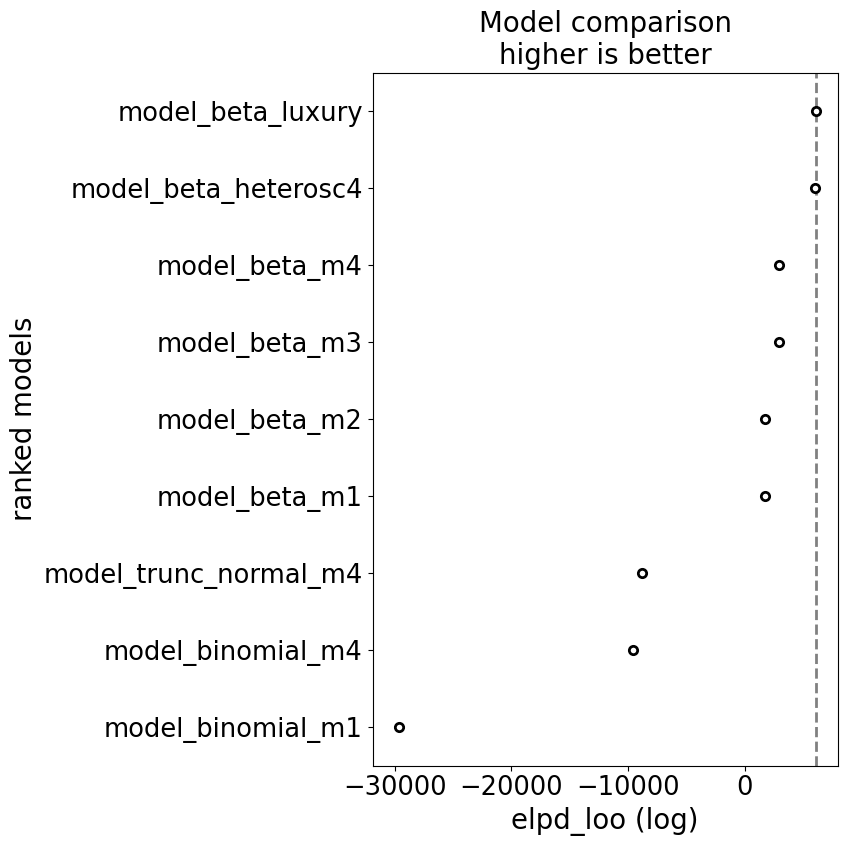

In [16]:
comp = az.compare(models, var_name='y_obs')
print(comp)
az.plot_compare(comp)